In [1]:
# This hidden cell is used for local execution of the notebook file, it does not appear in the published book

# Setup working directory
import os, re

dir_match = re.search(
    r".+ons-spark$",
    str(os.getcwd())
)

if not dir_match: os.chdir('../../..')

# Setup Spark environment variables for local use
import findspark
findspark.init()

## Spark and Visualisation

Visualising data with a graph or dashboard can be a useful way to show or discover trends that may not be obvious if just looking at the raw data. Visualisation can be useful throughout any coding project when working with data. At the start of a project graphs can assist in noticing patterns or outliers that you may not notice if just viewing the raw data. They can also help communicate interim and final results of analysis to stakeholders who aren't programmers. Visualisations are extensively used in official statistical publications produced by the ONS.

Spark has an additional challenge when it comes to charts and dashboards: your data will often be large, and if your data will not fit on the driver it will not be able to be visualised using a chart. Good practice for data visualisation when using Spark is therefore to aggregate the data, ensuring it is small enough to fit on the driver, use [`.toPandas()`](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.toPandas.html) if using PySpark or [`collect()`](https://dplyr.tidyverse.org/reference/compute.html) if using sparklyr, and then use the regular charting packages, e.g. [Matplotlib](https://matplotlib.org/) or [ggplot2](https://ggplot2.tidyverse.org/).

Good resources on visualisation include the [ONS Style Guide: Presenting Data](https://style.ons.gov.uk/category/data-visualisation/). All ONS charts should follow this guidance and those producing work on behalf of other organisations can also use this guide as an authority too. The [GSS Style Guide: Introduction to data visualisation](https://gss.civilservice.gov.uk/policy-store/introduction-to-data-visualisation/) is another good resource and contains useful links to further assist in presenting data effectively.

### An example: aggregating the Animal Rescue data by year

First, read in the data with Spark and aggregate to the level required in the chart. In this example, we will get the number of animals rescued by year:

In [2]:
import yaml
from pyspark.sql import SparkSession, functions as F

spark = SparkSession.builder.master("local").appName("data-viz").getOrCreate()

with open("config.yaml") as f:
    config = yaml.safe_load(f)
    
rescue_path = config["rescue_path"]
rescue = (spark.read.parquet(rescue_path)
          .groupBy("cal_year")
          .count()
          .orderBy("cal_year"))

```r
library(sparklyr)
library(dplyr)
library(ggplot2)

default_config <- sparklyr::spark_config()

sc <- sparklyr::spark_connect(
    master = "local",
    app_name = "data-viz",
    config = default_config)

config <- yaml::yaml.load_file("config.yaml")

rescue <- sparklyr::spark_read_parquet(sc, config$rescue_path) %>%
    dplyr::group_by(cal_year) %>%
    dplyr::summarise(count = n()) %>%
    dplyr::arrange(cal_year)
```

Now copy the data to to the driver, with `.toPandas()` if using Python or `collect()` if using R:

In [3]:
rescue_pd = rescue.toPandas()

```r
rescue_tb <- rescue %>% sparklyr::collect()
```

There are several popular charting packages available for Python. Examples include [Matplotlib](https://matplotlib.org/) and [Plotly](https://plotly.com/python/). A pandas DataFrame can also be visualised directly with `.plot()`, which will often be the quickest and easiest way if using Spark. `.plot()` is just a wrapper for Matplotlib's `plt.plot()`.

<Axes: xlabel='cal_year'>

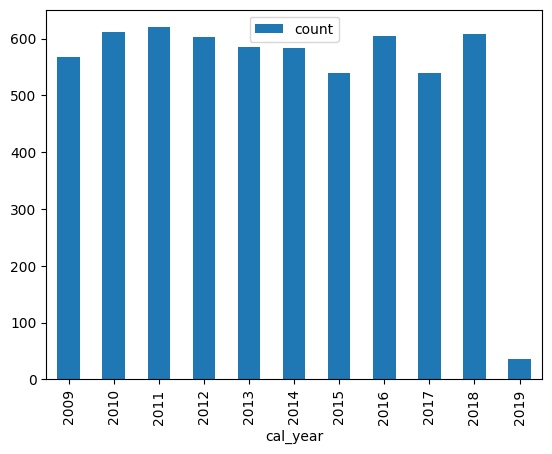

In [4]:
%matplotlib inline
rescue_pd.set_index("cal_year", drop=True, inplace=True)
rescue_pd.plot(kind="bar")

```{figure} ../images/viz_1_python.png
---
width: 100%
name: MatplotlibChart
alt: Matplotlib chart of animal rescue incidents by calendar year
---
```

Common R charting packages include [ggplot2](https://ggplot2.tidyverse.org/) and [Plotly](https://plotly.com/r/). Once the data is collected to the driver as a tibble these packages can be used normally.

In this example, `cal_year` is discrete and so is converted to a factor before charting.

```r
ggplot2::ggplot(data=rescue_tb, ggplot2::aes(x=as.factor(cal_year), y=count)) +
    ggplot2::geom_bar(stat="identity") +
    ggplot2::labs(x="cal_year")
```

```{figure} ../images/viz_2_r.png
---
width: 100%
name: ggplot2Chart
alt: ggplot2 chart of animal rescue incidents by calendar year
---
```

You can pass a sparklyr DataFrame directly into [`ggplot()`](https://ggplot2.tidyverse.org/reference/ggplot.html), although this could lead to errors if the data are too large. It is better to aggregate the data first and `collect()`.

```r
ggplot2::ggplot(data=rescue, ggplot2::aes(x=as.factor(cal_year), y=count)) +
    ggplot2::geom_bar(stat="identity") +
    ggplot2::labs(x="cal_year")
```

```{figure} ../images/viz_2_r.png
---
width: 100%
name: ggplot2Chart
alt: ggplot2 chart of animal rescue incidents by calendar year
---
```

### Dashboards

The principles for using [dashboards](https://style.ons.gov.uk/data-visualisation/dashboards/) with Spark are the same as for charts: aggregate the data first using Spark, then use these data to power the dashboard. In theory you could have a dashboard to power a Spark process which then returns an aggregated result, although this would likely have a negative impact on the user experience given the processing time and subsequent lag.

Common dashboard applications include [Seaborn](https://seaborn.pydata.org/) and [Streamlit](https://streamlit.io/) for Python and [Shiny](https://shiny.rstudio.com/) for R.

### Further Resources

PySpark Documentation:
- [`.toPandas()`](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.toPandas.html)

sparklyr and tidyverse Documentation:
- [`collect()`](https://dplyr.tidyverse.org/reference/compute.html)
- [`ggplot()`](https://ggplot2.tidyverse.org/reference/ggplot.html)

Guidance on data visualisation:
- [ONS Style Guide: Presenting Data](https://style.ons.gov.uk/category/data-visualisation/)
- [ONS Style Guide: Dashboards](https://style.ons.gov.uk/data-visualisation/dashboards/)
- [GSS Style Guide: Introduction to data visualisation](https://gss.civilservice.gov.uk/policy-store/introduction-to-data-visualisation/)

Charting and dashboard packages:
- [Matplotlib](https://matplotlib.org/)
- [ggplot2](https://ggplot2.tidyverse.org/)
- [Plotly: R](https://plotly.com/r/)
- [Plotly: Python](https://plotly.com/python/)
- [`pandas.DataFrame.plot`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.html)
- [Seaborn](https://seaborn.pydata.org/) 
- [Streamlit](https://streamlit.io/)
- [Shiny](https://shiny.rstudio.com/)